# STA414/2104 (Winter 2022) Probabilistic ML: Homework 3

- **Deadline**: Wed, March 23
- **Submission**: You need to submit your solutions through Crowdmark, including all your derivations, plots, and your code. You can produce the files however you like (e.g. $\LaTeX$, Microsoft Word, etc), as long as it is readable. Points will be deducted if we have a hard time reading your solutions or understanding the structure of your code.
- **Collaboration policy**: After attempting the problems on an individual basis, you may discuss and work together on the assignment with up to two classmates. However, **you must write your own code and write up your own solutions individually and explicitly name any collaborators** at the top of the homework.

## Your Info

- **Name: TONGFEI ZHOU**
- **Student Number: 1004738448**
- **Collaborators: Yichen Ji**

# 1. [50pts] Stochastic Variational Inference in the TrueSkill Model

## Background

We'll continue working with [TrueSkill](http://papers.nips.cc/paper/3079-trueskilltm-a-bayesian-skill-rating-system.pdf) model, a player ranking system for competitive games originally developed for Halo 2. Recall the model:


## Model definition

We assume that each player has a true, but unknown skill $z_i \in \mathbb{R}$.
We use $N$ to denote the number of players.

### The prior:
The prior over each player's skill is a standard normal distribution, and all player's skills are *a priori* independent.

### The likelihood:
For each observed game, the probability that player $i$ beats player $j$, given the player's skills $z_A$ and $z_B$, is:
$$p(A \,\, \text{beat} \,\, B | z_A, z_B) = \sigma(z_i - z_j)$$
where
$$\sigma(y) = \frac{1}{1 + \exp(-y)}$$
We chose this function simply because it's close to zero or one when the player's skills are very different, and equals one-half when the player skills are the same.  This likelihood function is the only thing that gives meaning to the latent skill variables $z_1 \dots z_N$.

There can be more than one game played between a pair of players. The outcome of each game is independent given the players' skills.
We use $M$ to denote the number of games.


In [ ]:
!pip install wget
import os
import os.path
import matplotlib.pyplot as plt
import wget
import jax
import jax.numpy as np
import scipy.io
import scipy.stats
import matplotlib.pyplot as plt

from jax import jit, grad
from jax.ops import index_update
from jax.random import PRNGKey, normal, split, uniform
from jax.scipy.stats import norm
from jax import random, vmap
from jax.example_libraries import optimizers
from tqdm import trange, tqdm_notebook
from functools import partial

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=6ca41fc28af24327fa39e70d6bda6a544c749513e790cce025913a4fc3b32ba5
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


# 1.1 [0pts] Implementing the TrueSkill Model



This part was mostly done in Assignment 2. We will recall some useful functions.

**a)** The function $\texttt{log_joint_prior}$ computes the log of the prior, jointly evaluated over all player's skills.

In [ ]:
def log_joint_prior(zs_array):
    return np.sum(norm.logpdf(zs_array, 0.0, 1.0), axis=-1)

**b)** The function `logp_a_beats_b` that, given a pair of skills $z_a$ and $z_b$, evaluates the log-likelihood that player with skill $z_a$ beat player with skill $z_b$ under the model detailed above.

To ensure numerical stability, we use the function `np.log1p` that computes $\log(1 + x)$ in a numerically stable way.  Or even better, use `np.logaddexp`.

In [ ]:
def logp_a_beats_b(z_a, z_b):
    return -np.logaddexp(0.0, z_b - z_a)

def log_prior_over_2_players(z1, z2):
    return norm.logpdf(z1, 0.0, 1.0) + norm.logpdf(z2, 0.0, 1.0)

def prior_over_2_players(z1, z2):
    return np.exp(log_prior_over_2_players(z1, z2))

def log_posterior_A_beat_B(z1, z2):
    return log_prior_over_2_players(z1, z2) + logp_a_beats_b(z1, z2)

def posterior_A_beat_B(z1, z2):
    return np.exp(log_posterior_A_beat_B(z1, z2))

def log_posterior_A_beat_B_10_times(z1, z2):
    return log_prior_over_2_players(z1, z2) + 10.0 * logp_a_beats_b(z1, z2)

def posterior_A_beat_B_10_times(z1, z2):
    return np.exp(log_posterior_A_beat_B_10_times(z1, z2))

def log_posterior_beat_each_other_10_times(z1, z2):
    return log_prior_over_2_players(z1, z2) \
        + 10.* logp_a_beats_b(z1, z2) \
        + 10.* logp_a_beats_b(z2, z1)

def posterior_beat_each_other_10_times(z1, z2):
    return np.exp(log_posterior_beat_each_other_10_times(z1, z2))

The following functions will be used for plotting.  Note that `plot_2d_fun` can now take an optional second function, so you can compare two functions.

In [ ]:
# Plotting helper functions for free
def plot_isocontours(ax, func, xlimits=[-3, 3], ylimits=[-3, 3], numticks=101, cmap="summer"):
    x = np.linspace(*xlimits, num=numticks)
    y = np.linspace(*ylimits, num=numticks)
    X, Y = np.meshgrid(x, y)
    zs = func(X.ravel(), Y.ravel())
    Z = zs.reshape(X.shape)
    plt.contour(X, Y, Z, cmap=cmap)
    ax.set_yticks([])
    ax.set_xticks([])

def plot_2d_fun(f, x_axis_label="", y_axis_label="", f2=None, scatter_pts=None):
    # This is the function your code should call.
    # f() should take two arguments.
    fig = plt.figure(figsize=(8,8), facecolor='white')
    ax = fig.add_subplot(111, frameon=False)
    ax.set_xlabel(x_axis_label)
    ax.set_ylabel(y_axis_label)
    plot_isocontours(ax, f)
    if f2 is not None:
      plot_isocontours(ax, f2, cmap='winter')

    if scatter_pts is not None:
      plt.scatter(scatter_pts[:,0], scatter_pts[:, 1])
    plt.plot([3, -3], [3, -3], 'b--')   # Line of equal skill
    plt.show(block=True)
    plt.draw()    

## **1.2 [25pts]** Stochastic Variational Inference on Two Players and Toy Data

One nice thing about a Bayesian approach is that it separates the model specification from the approximate inference strategy.
The original Trueskill paper from 2007 used message passing.

In this question we will  approximate posterior distributions with gradient-based stochastic variational inference.

You'll use a fully-factorized Gaussian approximation to the posterior.
The variational parameters for each latent variable in the model are $\phi_d = (\mu_d,\log(\sigma_d))$. Notice that instead of $\sigma_d$ (which is constrained to be positive), we work with $\log(\sigma_d)$, removing the constraint. This way, we can do unconstrained gradient-based optimization.



**a) [15pt]** Implement the missing lines in the below code, to complete the evidence lower bound function and the reparameterized sampler for the approximate posterior.

Hint 1: You must use the reparametrization trick in your sampler if you want your gradients to be unbiased.

Hint 2: Instead of including batch dimensions, you can simply use the `vmap` higher-order function, which takes in a function and returns another one that broadcasts the first function along a new axis.

Hint 3: If you're worried you got these wrong, you can check that the sampler matches the log pdf by plotting a histogram of samples against a plot of the pdf.

In [ ]:
def diag_gaussian_sample(rng, mean, log_std):
  # Take a single sample from a diagonal multivariate Gaussian.
  return mean + np.exp(log_std) * random.normal(rng, mean.shape)
  # You might want to use random.normal(), but remember
  # you must use the reparameterization trick.  Also remember that
  # we are parameterizing the _log_ of the standard deviation.

def diag_gaussian_logpdf(x, mean, log_std):
  # Evaluate the density of single point on a diagonal multivariate Gaussian.
  return np.sum(norm.logpdf(x, mean, np.exp(log_std)), axis = -1)

def elbo(logprob, rng, mean, log_std):
  # Single-sample Monte Carlo estimate of the variational lower bound.
  sampled_zs = diag_gaussian_sample(rng, mean, log_std)
  return logprob(sampled_zs) - diag_gaussian_logpdf(sampled_zs, mean, log_std)

def batch_elbo(logprob, rng, params, num_samples):
  # Average over a batch of random samples. 
  rngs = random.split(rng, num_samples)
  vectorized_elbo = vmap(partial(elbo, logprob), in_axes=(0, None, None))
  elbo_estimates = vectorized_elbo(rngs, *params)
  return np.mean(elbo_estimates)
  # TODO: Use simple Monte Carlo to combine your estimates
  


**b) [4pts]** Write a loss function called $\texttt{objective}$  that takes variational distribution parameters and returns an unbiased estimate of the negative elbo using $\texttt{num_samples_per_iter}$ samples, to approximate the joint posterior over skills conditioned on observing player A winning 10 games.

Note: We want a _negative_ ELBO estimate, because the convention in optimization is to minimize functions, and we want to maximize the ELBO.

In [ ]:
# Hyperparameters
num_players = 2
n_iters = 800
stepsize = 0.0001
num_samples_per_iter = 50
key = PRNGKey(0)

def log_posterior_A_beat_B_10_times_1_arg(z1z2):
  return log_posterior_A_beat_B_10_times(z1z2[0], z1z2[1])

def objective(params, t):  # The loss function to be minimized.
  rng = random.PRNGKey(t)
  return -batch_elbo(log_posterior_A_beat_B_10_times_1_arg, rng, params, 
                      num_samples_per_iter)
  # TODO.  Hint:  This can be done in one line.

**c) [1pts]** Initialize a set of variational parameters and optimize them to approximate the joint where we observe player A winning 10 games. Report the final loss. Also plot the optimized variational approximation contours and the target distribution on the same axes.

Hint:  Any initialization should be fine.  How many variational parameters do you need to specify a fully-factorized Gaussian approximate posterior?

Optimizing variational parameters...


 12%|█▏        | 99/800 [00:00<00:02, 257.69it/s]

Iteration 0 lower bound -4.891197204589844
Iteration 25 lower bound -3.186821937561035
Iteration 50 lower bound -3.0231268405914307
Iteration 75 lower bound -3.071540355682373
Iteration 100 lower bound -2.9227817058563232
Iteration 125 lower bound -3.0607521533966064
Iteration 150 lower bound -2.9616291522979736


 34%|███▍      | 276/800 [00:00<00:00, 536.16it/s]

Iteration 175 lower bound -2.933382749557495
Iteration 200 lower bound -2.9295949935913086
Iteration 225 lower bound -3.0403811931610107
Iteration 250 lower bound -2.9081029891967773
Iteration 275 lower bound -3.0254147052764893
Iteration 300 lower bound -2.9337174892425537
Iteration 325 lower bound -2.915977954864502
Iteration 350 lower bound -3.0472404956817627


 60%|█████▉    | 476/800 [00:00<00:00, 699.38it/s]

Iteration 375 lower bound -3.0245940685272217
Iteration 400 lower bound -2.90017032623291
Iteration 425 lower bound -3.0051774978637695
Iteration 450 lower bound -2.9029064178466797
Iteration 475 lower bound -3.0870468616485596
Iteration 500 lower bound -2.9341259002685547
Iteration 525 lower bound -2.8127903938293457


 84%|████████▍ | 676/800 [00:01<00:00, 798.26it/s]

Iteration 550 lower bound -3.142521381378174
Iteration 575 lower bound -3.099687099456787
Iteration 600 lower bound -2.7920751571655273
Iteration 625 lower bound -2.9612951278686523
Iteration 650 lower bound -3.0898995399475098
Iteration 675 lower bound -2.9484965801239014
Iteration 700 lower bound -2.8852996826171875
Iteration 725 lower bound -2.948615074157715


100%|██████████| 800/800 [00:01<00:00, 608.41it/s]


Iteration 750 lower bound -2.8670494556427
Iteration 775 lower bound -2.976224184036255


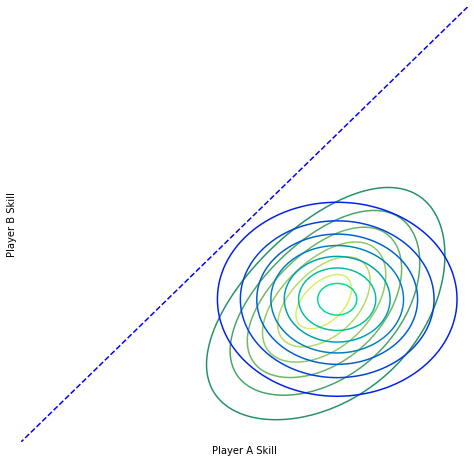

<Figure size 432x288 with 0 Axes>

In [ ]:
def callback(params, t):
  if t % 25 == 0:
    print("Iteration {} lower bound {}".format(t, -objective(params, t)))

# Set up optimizer.
D = 2
init_mean     = np.zeros(D)
init_log_std  = np.zeros(D) # TODO
init_params = (init_mean, init_log_std)
opt_init, opt_update, get_params = optimizers.momentum(step_size=0.1, mass=0.9)
opt_state = opt_init(init_params)

@jit
def update(i, opt_state):
    params = get_params(opt_state) 
    gradient = grad(objective)(params, i)
    return opt_update(i, gradient, opt_state)

# Main loop.
print("Optimizing variational parameters...")
for t in trange(0, n_iters):
    opt_state = update(t, opt_state)
    params = get_params(opt_state)
    callback(params, t)


def approx_posterior_2d(z1, z2):
    # The approximate posterior
    mean, logstd = params
    return np.exp(diag_gaussian_logpdf(np.array([z1, z2]), mean, logstd))

approx_posterior_2d_batched = vmap(approx_posterior_2d, in_axes=(0, 0))

plot_2d_fun(posterior_A_beat_B_10_times, "Player A Skill", "Player B Skill",
            f2=approx_posterior_2d_batched)

The final loss is approximately $-2.976$

**d) [4pt]** Write a loss function called $\texttt{objective}$  that takes variational distribution parameters and returns a negative elbo estimate using simple Monte carlo with $\texttt{num_samples_per_iter}$ samples, to approximate the joint where we observe player A winning 10 games and player B winning 10 games.

Hint:  You can find analogous functions in the code above.


In [ ]:
# Hyperparameters
n_iters = 100
stepsize = 0.0001
num_samples_per_iter = 50
key = PRNGKey(0)

def log_posterior_beat_each_other_10_times_1_arg(z1z2):
  return log_posterior_beat_each_other_10_times(z1z2[0], z1z2[1])
  # TODO

def objective(params, t):
  rng = random.PRNGKey(t)
  return -batch_elbo(log_posterior_beat_each_other_10_times_1_arg, rng, params, 
                      num_samples_per_iter)
  # TODO

**e) [1pts]** Run the code below to optimize, and report the final loss. Also plot the optimized variational approximation contours and the target distribution on the same axes.

Write one or two sentences describing the joint settings of skills that are plausible under the true posterior, but which are not plausible under the approximate posterior.

Finally, answer with one or two sentences:  Would changing the variational approximate posterior from a fully-factorized (diagonal covariance) Gaussian to a non-factorized (fully parameterized covariance) Gaussian make a better approximation in this instance?

Optimizing variational parameters...


100%|██████████| 100/100 [00:00<00:00, 186.58it/s]

Iteration 0 lower bound -17.624521255493164
Iteration 25 lower bound -15.784345626831055
Iteration 50 lower bound -15.823676109313965
Iteration 75 lower bound -15.860443115234375


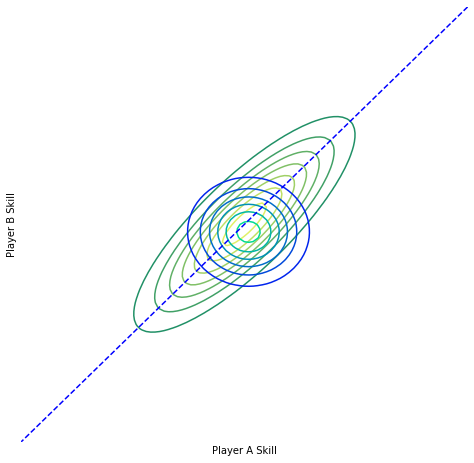

<Figure size 432x288 with 0 Axes>

In [ ]:
@jit
def update(i, opt_state):
    params = get_params(opt_state)
    gradient = grad(objective)(params, i)
    return opt_update(i, gradient, opt_state)

# Main loop.
print("Optimizing variational parameters...")
for t in trange(0, n_iters):
    opt_state = update(t, opt_state)
    params = get_params(opt_state)
    callback(params, t)

def approx_posterior_2d(z1, z2):
    mean, logstd = params
    return np.exp(diag_gaussian_logpdf(np.array([z1, z2]), mean, logstd))

approx_posterior_2d_batched = vmap(approx_posterior_2d, in_axes=(0, 0))

plot_2d_fun(posterior_beat_each_other_10_times, "Player A Skill", "Player B Skill",
            f2=approx_posterior_2d_batched)


The final loss is approximately $-15.86$
* The joint settings of skills that are plausible under the true posterior, but which are not plausible under the approximate posterior can be that, the skill of player A is the same as the skill of player B.
* It would make a better approxmiation since from the graph, one can see that the true posterior is showing correlation between the skill of player A and B from the oval plotting, which means that the covariance term is not zero.

## 1.3 [25pts] Approximate inference conditioned on real data

The dataset from $\texttt{tennis_data.mat}$ contains data on 1801 tennis games amongst 107 players:
 - W is a 107 by 1 matrix, whose $i$’th entry is the name of player $i$.
 - G is a 1801 by 2 matrix of game outcomes (actually tennis matches), one row per game.

The first column contains the indices of the players who won.
The second column contains the indices of the player who lost.





In [ ]:
wget.download("https://probmlcourse.github.io/csc412/assignments/assignment_2/tennis_data.mat")
data = scipy.io.loadmat('tennis_data.mat')

games = data['G'] - 1 # A list of pairs of player numbers, representing game outcomes. (shape (1081, 2))
names = data['W']     # A list of names of players, corresponding to the player numbers. (shape (107, 1))

print(games[0,:])
print(names[0])

[0 1]
[array(['Rafael-Nadal'], dtype='<U12')]




**a) [0pt]** Assuming all game outcomes are i.i.d. conditioned on all players' skills, the function $\texttt{log_games_likelihood}$ takes a batch of player skills $\texttt{zs}$ and a collection of observed games $\texttt{games}$ and gives the total log-likelihood for all those observations given all the skills.


In [ ]:
def log_games_likelihood(zs, games):
  # matches is an array of size (num_games x 2)
  # zs is an array of size (num_players, num_samples)

  winning_player_ixs = games[:,0]
  losing_player_ixs = games[:,1]

  winning_player_skills = zs[winning_player_ixs] 
  losing_player_skills = zs[losing_player_ixs] 
  log_likelihoods = logp_a_beats_b(winning_player_skills, losing_player_skills) 
  return np.sum(log_likelihoods)

In [ ]:
def log_joint_probability(zs):
    return log_joint_prior(zs) + log_games_likelihood(zs, games)

**b) [4pt]** Write a new objective function like the one from the previous question. 

Below, we initialize a variational distribution and fit it to the joint distribution with all the observed tennis games from the dataset. Report the final negative ELBO estimate after optimization.

In [ ]:
# Hyperparameters
num_players = 107
n_iters = 500
stepsize = 0.0001
num_samples_per_iter = 150
key = PRNGKey(0)

def objective(params, t):
  rng = random.PRNGKey(t)
  return - batch_elbo(log_joint_probability, rng, params, num_samples_per_iter)
  # TODO

**c) [1pts]** Optimize, and report the final loss. 

In [ ]:
# Set up optimizer.
init_mean = np.zeros(num_players)
init_std  = np.zeros(num_players)
init_params = (init_mean, init_std)
opt_init, opt_update, get_params = optimizers.momentum(step_size=0.1, mass=0.9)
opt_state = opt_init(init_params)

@jit
def update(i, opt_state):
    params = get_params(opt_state)
    gradient = grad(objective)(params, i)
    return opt_update(i, gradient, opt_state)

# Main loop.
print("Optimizing variational parameters...")
for t in trange(0, n_iters):
    opt_state = update(t, opt_state)
    params = get_params(opt_state)
    callback(params, t)


Optimizing variational parameters...


 20%|██        | 101/500 [00:03<00:08, 46.89it/s]

Iteration 0 lower bound -1186.4822998046875
Iteration 25 lower bound -1172.82373046875
Iteration 50 lower bound -1146.538330078125
Iteration 75 lower bound -1144.3675537109375
Iteration 100 lower bound -1144.565673828125
Iteration 125 lower bound -1144.3048095703125
Iteration 150 lower bound -1144.0537109375
Iteration 175 lower bound -1144.3070068359375


 60%|██████    | 301/500 [00:03<00:01, 175.97it/s]

Iteration 200 lower bound -1144.236328125
Iteration 225 lower bound -1144.291748046875
Iteration 250 lower bound -1143.934814453125
Iteration 275 lower bound -1144.21728515625
Iteration 300 lower bound -1144.195068359375
Iteration 325 lower bound -1144.046875
Iteration 350 lower bound -1144.3035888671875
Iteration 375 lower bound -1144.3499755859375


100%|██████████| 500/500 [00:03<00:00, 145.00it/s]

Iteration 400 lower bound -1144.8079833984375
Iteration 425 lower bound -1144.3662109375
Iteration 450 lower bound -1143.9383544921875
Iteration 475 lower bound -1144.51611328125


The final loss is approximately $-1144$.

**d) [1pt]** Plot the approximate mean and variance of all players, sorted by skill.

<ErrorbarContainer object of 3 artists>

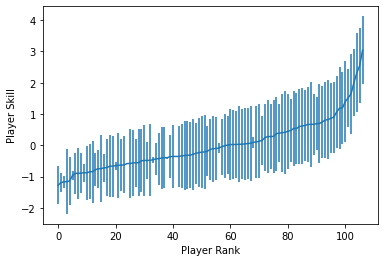

In [ ]:
mean_skills, logstd_skills = params # TODO.  Hint: You don't need to do simple Monte Carlo here.

order = np.argsort(mean_skills)

plt.xlabel("Player Rank")
plt.ylabel("Player Skill")
plt.errorbar(range(107), mean_skills[order], logstd_skills[order])

**e) [2pts]** List the names of the 10 players with the highest mean skill under the variational model.


In [ ]:
for i in range(1,11):
    print(names[order[-i]])

[array(['Novak-Djokovic'], dtype='<U14')]
[array(['Roger-Federer'], dtype='<U13')]
[array(['Rafael-Nadal'], dtype='<U12')]
[array(['Andy-Murray'], dtype='<U11')]
[array(['David-Ferrer'], dtype='<U12')]
[array(['Robin-Soderling'], dtype='<U15')]
[array(['Jo-Wilfried-Tsonga'], dtype='<U18')]
[array(['Juan-Martin-Del-Potro'], dtype='<U21')]
[array(['Tomas-Berdych'], dtype='<U13')]
[array(['Richard-Gasquet'], dtype='<U15')]


**f) [1pt]** Plot the joint posterior over the skills of Roger Federer and Rafael Nadal.

[array(['Rafael-Nadal'], dtype='<U12')]
[array(['Roger-Federer'], dtype='<U13')]


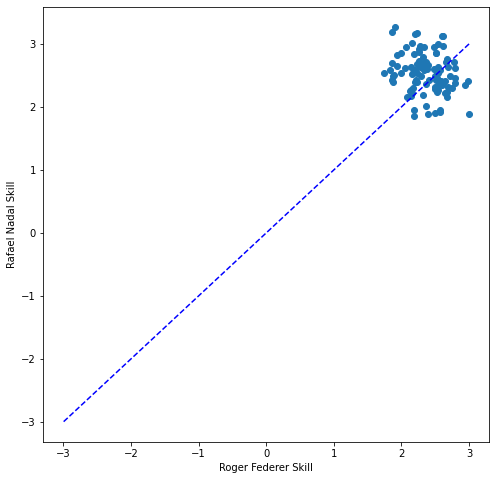

In [ ]:
nadal_ix = 0
federer_ix = 4
print(names[nadal_ix])
print(names[federer_ix])

fig = plt.figure(figsize=(8,8), facecolor='white')

# Label each with "<player> Skill"
plt.xlabel("Roger Federer Skill") 
plt.ylabel("Rafael Nadal Skill") 

plt.plot([3, -3], [3, -3], 'b--') # Line of equal skill

rngs = random.split(random.PRNGKey(t), 100)
samples = vmap(diag_gaussian_sample, in_axes=(0, None, None))(rngs, *params)

# TODO:  Hint:  Use plt.scatter()
plt.scatter(samples[:, nadal_ix], samples[:, federer_ix])

**g) [8pts]** One nice thing about using variational methods is that if we have a simple approximate posterior (like a Gaussian), we can sometimes compute expectations exactly.  In this question, we'll use math to find an exact formula for an expectation instead of using simple Monte Carlo.

Derive the exact probability under a factorized Gaussian over two players’ skills that one has higher skill than the other, as a function of the two means and variances over their skills. Express your answer in terms of the cumulative distribution function of a one-dimensional Gaussian random variable.

- Hint 1: Use a linear change of variables $y_A, y_B = z_A − z_B , z_B$. What does the line of equal skill look like after this transformation?
- Hint 2: If $X \sim \mathcal N (\mu, \Sigma)$, then $AX \sim \mathcal N (A\mu, A\Sigma A^T)$ where $A$ is a linear transformation.
- Hint 3: Marginalization in Gaussians is easy: if $X \sim \mathcal N (\mu, \Sigma)$, then the $i$th element of $X$ has a
marginal distribution $X_i \sim \mathcal N (\mu_i , \Sigma_{ii})$.

Since we assume that each player's skill is independent, we have as:
$$z_A \sim \mathcal N (\mu_A, \sigma_A^2), z_B \sim \mathcal N (\mu_B, \sigma_B^2)$$, then by the property of normal distribution, we have:
$$z_A - z_B \sim \mathcal N (\mu_A - \mu_B, \sigma_A^2 + σ_B^2)$$. Therefore, we have:
$$\mathcal P(z_A - z_B > 0) = 1 - \mathcal P(z_A - z_B \leq 0) = 1 - Φ(x)$$ where $x = \frac{(\mu_B - \mu_A)}{\sqrt{\sigma_A^2 + σ_B^2}}$

**h) [2pts]** Compute the probability under your approximate posterior that Roger Federer has higher skill than Rafael Nadal. Compute this quantity exactly using the formula you just derived above, and also estimate it using simple Monte Carlo with 10000 examples.

Hint:  You might want to use `jax.scipy.stats.norm.cdf` for the exact formula.

In [ ]:
# TODO
# Exact math formula
x = (mean_skills[nadal_ix] - mean_skills[federer_ix]) / (np.sqrt(np.exp(2 * logstd_skills[federer_ix]) + np.exp(2 * logstd_skills[nadal_ix])))
print(1 - norm.cdf(x))
# Simple Monte Carlo
rngs = random.split(random.PRNGKey(t), 10000)
samples = vmap(diag_gaussian_sample, in_axes=(0, None, None))(rngs, *params)
print(np.mean(samples[:, nadal_ix] < samples[:, federer_ix]))

0.71167904
0.7112


**i) [2pts]** Compute the probability that Roger Federer is better than the player with the lowest mean skill. Compute this quantity exactly, and then estimate it using simple Monte Carlo with 10000 examples.


In [ ]:
# TODO
# Exact math formula
x = (mean_skills[order[0]] - mean_skills[federer_ix]) / (np.sqrt(np.exp(2 * logstd_skills[federer_ix]) + np.exp(2 * logstd_skills[order[0]])))
print(1 - norm.cdf(x))
# Simple Monte Carlo
rngs = random.split(random.PRNGKey(t), 10000)
samples = vmap(diag_gaussian_sample, in_axes=(0, None, None))(rngs, *params)
print(np.mean(samples[:, order[0]] < samples[:, federer_ix]))

1.0
1.0


j) [2 pts] Imagine that we knew ahead of time that we were examining the skills of top tennis players, and so changed our prior on all players to Normal(10, 1) and re-ran our approximate inference from scratch. Would that change the answer of either of the previous 2 questions, in expectation?

This would not change the answer of either of the previous $2$ questions since the changed prior only shift the prior from location $0$ to location $10$ without changing the standard deviation. Therefore, during the training process of stochastic variational inference, we are just starting from another point ($\mu, \Sigma$), and still stochastic gradient descent can lead us to the final solution found above.

k) [2 pts] Based on all the plots and results in this assignment and HW2, which approximate inference method do you suspect is producing a better overall approximation to the true posterior over all skills conditioned on all games?  Give a short explanation.

I suspect HMC in HW2 is producing a better overall approximation since, first, the probability of Federer beats Nadal in SVI is approxmiately $0.712$, but actually these two players have similar play skills, and so I suspect the probability of $0.586$ produced by HMC is more accurate, and second, similar analysis can be applied to the Federer beating the lowest mean skill player, as the probability given by SVI is $1.0$, which saying that basically no chance lowest mean skill player can beat Federer, but anything is possible, and so $0.99901$ given by HMC is a little bit more sensible.